```
記得加上na 數量的新feat (也可以加na 數量std)，你們必須統一 CV 的分配

念慈: (your model response should be probability instead of classification label) 
1. Fit a Logistic regression model (Select K by CV) 
2. Fit a CART model 
3. Fit a Random Forest model 

永鴻: 
1. Hyperparameter tuning and feature engineering of LightGBM (AUC should be > 0.81) 
2. LightGBM Cross Validation (you may write it from scratch) 

語謙: 
1. Hyperparameter tuning and feature engineering of XGBoost (AUC should be > 0.81) 
2. XGBoost Cross Validation (you may write it from scratch) 

TO DO: 你們做完後合力做的事情
1. Voting: (XGBoost + LightGBM + CART + Random Forest + Logistic Regression) 
2. KDE plot of each model (XGBoost, LightGBM, CART, Random Forest, Logistic Regression) 
3. Heatmap of each model (XGBoost, LightGBM, CART, Random Forest, Logistic Regression) 
4. Fit a CatBoost model 
```
CatBoost : https://ithelp.ithome.com.tw/articles/10275263
```
5. Power Averaging each model (if the correlation of heatmap > threshold (0.95))
```

**看變數分布**
- sns.displot( df [ 'f1' ] ,bins=50,kde=True )
- sns.kdeplot( df [ 'f1' ] )
- sns.histplot(transform_data, kde=True)

- plt.show()

# 核密度估計(Kernel Density Estimation)

- 直方圖缺陷 : 結果易受到長條寬度的影響，bin太少時，視覺上就與原先圖形非常不相似、不準確


- 核密度估計與直方圖密切相關，但可以通過使用合適的核賦予其平滑性或連續性等屬性


- 核函數：uniform、triangular、biweight、triweight、Epanechnikov、normal 等


- 平滑算法使用高斯核，所以估計的密度曲線可以擴展到對特定數據集沒有意義的值

**核函數(Kernel function)**

- 機率密度函數，表達隨機變數落在特定值的可能性


- 核函數具有對稱的性質，且在中心點位置皆是波峰


**核密度估計(Kernel Density Estimation)**

- $f_n(x) \;=\; \frac{1}{n h}\;\sum^{n}_{i=1}\;K(\frac{x-x_i}{h})$
```
K : 核函數，類似權重的效果
h : 帶寬，用來控制密度分布的平滑程度，數值越大，則折線圖越平滑
逐一計算 x 與任一樣本 xi 的距離，最後除以全部樣本數 n，就可以計算出可能性是多少
再把可能性的結果帶入核函數
```

- $K(x) \;=\; \frac{1}{\sqrt{2\pi}}\;exp(-\frac{x^2}{2})$ , 這裡為高斯函數 , 扮演類似權重的作用


- 用來估計未知的機率密度函數。
- 核心思想是，如果數據點距離所要求的 x 平均起來很近的話，那這個x出現的概率就很大
- 而這個距離的計算是引進核函數來做為權重，就類似將距離轉換為概率的意思，但中心思想不變

來源 : https://medium.com/qiubingcheng/%E7%99%BD%E8%A9%B1%E8%A7%A3%E9%87%8B%E6%A0%B8%E5%AF%86%E5%BA%A6%E4%BC%B0%E8%A8%88-kernel-density-estimation-18c4913f0b6a

- 機器學習常犯錯的十件事 : https://ithelp.ithome.com.tw/articles/10279778

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##### (評分指標)
from sklearn.metrics import roc_auc_score, confusion_matrix

##### 由多種方法組成，在各種迭代器中用於計算快速且代碼高效的解決方案
import itertools                        # 用在 confusion matrix

##### Progress bar (進度條)
from tqdm import tqdm

##### KFOLD
from sklearn.model_selection import KFold


## confusion matrix 圖的配置，把矩陣化成圖

In [2]:
##### you may import itertools

def plot_confusion_matrix(cm, classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)   # interpolation : 插值 
    plt.title('Confusion matrix', fontweight='bold', pad=15)     # 字體重量 :'bold'(粗體), pad : 標題放置距離
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))                # classes : list，的長度，的 array，X 的位置
    plt.xticks(tick_marks, classes, rotation=0)         # xticks : 把坐標軸變成自己想要的樣子，類似覆蓋，覆蓋長度要和原來坐標長度一致
    plt.yticks(tick_marks, classes)                     # rotation=0 : 以度為單位的角度
                                                        # rotation='vertical' : 跟座標垂直
    
    thresh = cm.max() / 2.                              # threshold (臨界點)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                                                        # itertools.product : 兩個集合的笛卡爾積，定義為所有有序對 (a, b) 的集合
                                                        # ex : (0,0)、(0,1)、(1,0)、(1,1)
        plt.text(j, i, format(cm[i, j], 'g'),           # 'd' 十進制整數，輸出以 10 為底的數字，細節 : help('FORMATTING')
                 horizontalalignment="center",          # 水平對齊 {'center', 'right', 'left'}
                 color="white" if cm[i, j] > thresh else "black")
                                                        # 數字大於 threshold (臨界點)，給白色，因為 Blues 是淺藍到深
                                                        # 'g' 浮點數 & 整數 ...
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()                                  # 調整子圖之間和周圍的填充
 

In [3]:
# 直接用加 NaN 數量的資料

df_train = pd.read_csv(r"C:\Users\user\Desktop\2022data\na_number.csv",index_col='id')
df_test = pd.read_csv(r"C:\Users\user\Desktop\2022data\na_number_test.csv",index_col='id')

#路徑字串開頭要寫 r & 檔案名稱.csv                         
# r :為了不讓 \ 被讀成特殊字元 EX: \n
#指定欄位 id 為索引 (取代原本 0.1...957918的位置)

# df_train.isnull().sum().sum() # 還有缺失值嗎  # 1820782
# df_train.isnull().sum().sum() # 還有缺失值嗎  # 1820782

df_train.head()


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f111,f112,f113,f114,f115,f116,f117,f118,Nanumber,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,5,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,2,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,8,1


In [4]:
df_test.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,Nanumber
id,,,,,,,,,,,,,,,,,,,,,
957919,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,6221.000,...,-22.1890,2.0655,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357,1
957920,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,934.430,...,-1.6342,1.5736,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125,0
957921,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,131.810,...,-32.7800,2.1364,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797,1
957922,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,-26.473,...,-2.4162,1.5199,-0.011633,1.3840,26849.0,1.1490,2.138800e+17,6173.3,0.32910,0
957923,0.079947,-0.006919,10574.00,0.34845,0.45008,-1.84200,3027.00,428150.0,9.291500e+11,5999.400,...,-18.6300,3.7387,0.757080,-4.9405,50336.0,1.2488,2.151300e+17,2250.1,0.33796,0


In [5]:
# K-Fold 資料

# Xtrain = train_df.copy().loc[:,'f1':'f118']
# Ytrain = train_df.copy().loc[:,'claim']
# Xtest = test_df.copy()

Xtrain = df_train.copy().loc[:,'f1':'Nanumber']
Ytrain = df_train.copy().loc[:,'claim']
Xtest = df_test.copy()


# 3. Fit a Random Forest model
`概率模型（樹形模型）不需要歸一化，不關心變量的值，而是關心變量的分佈(各個特徵出現的機率)和變量之間的條件概率，如決策樹、RF`

- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

- 詞彙表 : https://scikit-learn.org/stable/glossary.html#term-n_jobs

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split  

In [7]:
# K-Fold 資料     # max_depth = 5

# Xtrain = train_df.copy().loc[:,'f1':'f118']
# Ytrain = train_df.copy().loc[:,'claim']
# Xtest = test_df.copy()

# 直接跑不用 kfold

Xtrain = Xtrain.fillna(0)                              # 補 0
Xtest = Xtest.fillna(0)                                # RFs 不能有 NaN，
                                                       # python 裡 sklearn 不能，pycaret 能，原理上隨機森林是支持有缺失值的

train_data, test_data, train_target, test_target = train_test_split(Xtrain, Ytrain, test_size=0.2,random_state=24)
    
rf_model = RandomForestClassifier(max_depth=5, max_features= 'sqrt',
                                  max_samples=None, criterion= 'gini',
                                  oob_score=True, bootstrap=True)
rf_model.fit(train_data, train_target)
# y_new = rf_model.predict(Xtrain)

# 機率分類判斷
rf_predictions = rf_model.predict_proba(test_data) 

rf_score = roc_auc_score(test_target, rf_predictions[:,-1]) # (957919,)
print(rf_score)

########                                                                                  ###############
########  n_jobs = -1，動用所有 CPU                                                        ###############
########                                                                                  ###############


0.7928942487157519


In [8]:
# K-Fold 資料     # max_depth = 60

# Xtrain = train_df.copy().loc[:,'f1':'f118']
# Ytrain = train_df.copy().loc[:,'claim']
# Xtest = test_df.copy()

# 直接跑不用 kfold

Xtrain = Xtrain.fillna(0)                              # 補 0
Xtest = Xtest.fillna(0)                                # RFs 不能有 NaN，
                                                       # python 裡 sklearn 不能，pycaret 能，原理上隨機森林是支持有缺失值的

train_data, test_data, train_target, test_target = train_test_split(Xtrain, Ytrain, test_size=0.2,random_state=24)
    
rf_model = RandomForestClassifier(max_depth=60, max_features= 'sqrt',
                                  max_samples=None, criterion= 'gini',
                                  oob_score=True, bootstrap=True)
rf_model.fit(train_data, train_target)
# y_new = rf_model.predict(Xtrain)

# 機率分類判斷
rf_predictions = rf_model.predict_proba(test_data) 

rf_score = roc_auc_score(test_target, rf_predictions[:,-1]) # (957919,)
print(rf_score)

########                                                                                  ###############
########  n_jobs = -1，是啥意思                                                            ###############
########                                                                                  ###############


0.7995234438403136


# K-Fold

In [9]:
# max_depth = 5


Xtrain = Xtrain.fillna(0)                         # 補 0
Xtest = Xtest.fillna(0)                           # RFs 不能有 NaN，
                                                  # python 裡 sklearn 不能，pycaret 能，原理上隨機森林是支持有缺失值的
##### Set your configuration(配置) here!!

FOLD = 5                                          # 切 5 分
SEEDS = [24, 42]                                  # 要做幾次 K-fold ,這裡做 2 次

fet_imp = 0                                       # feature importance (not necessary)  # 看特徵重要性
counter = 0                                       # 整個迴圈的個數
oof_score = 0                                     # oof_score /= float(counter)，整個 kfold 的平均分數，roc_auc_score                         

##### here I use XGBoost to implement KFold, you may choose your model by your self
y_pred_final_rf = np.zeros((Xtest.shape[0], 1))   # 建 2維 0 陣列
y_pred_meta_rf = np.zeros((Xtrain.shape[0], 1))  

##### your chosen seeds
for sidx, seed in tqdm(enumerate(SEEDS)):         # enumerate(枚舉) : 看list物件，(0,24) 第一次 & (1,42) 第二次
    seed_score = 0                                # 累積每次 kfold 完分數，後面拿去算每次的平均分數

    ##### start KFold

    kfold = KFold(n_splits=FOLD, shuffle=True, random_state=seed)   # shuffle : 打亂，第 n 次的 random_state 
  # kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed) 

    for flod_idx, (train_idx, val_idx) in enumerate(kfold.split(Xtrain.values, Ytrain.values)): 
                                  # ('f1:f118' & 'claim') 分別對 data 跟 label 切出訓練 & 驗證集，後面 fit 用
                                  # kfold.split : 生成 index 以將數據拆分為訓練集和測試集 
                                  # KFold()方法中的 split()：split(a,b)：方法會根據折數對 a 和 b 進行劃分，返回相應數據的下標
                                  # DF --> array , Xtrain.values (957919, 118)    
        counter += 1              # 整個做到第 (kfold 裡切幾次*做幾次 kflod) 次 

        ##### setting sub training data and validation data
        train_x, train_y = Xtrain.iloc[train_idx], Ytrain.iloc[train_idx]     # 拿出切好的訓練 & 驗證集 (train, val)
        val_x, val_y = Xtrain.iloc[val_idx], Ytrain.iloc[val_idx]             # K-Flod 做完

############################################################################  # 以下以 Random forest 為例  ###############
        ##### This is nothing to do with KFold (建)

        rf_model = RandomForestClassifier(max_depth=5, max_features= 'sqrt',
                                          max_samples=None, criterion= 'gini',
                                          oob_score=True, bootstrap=True)
        rf_model.fit(train_x, train_y)
        # y_new = rf_model.predict(Xtrain)      

        ##### predict validation set and testing set       # 預測 驗證集 & 測試集
        
        y_pred = rf_model.predict_proba(val_x)[:,-1]            
        y_pred_meta_rf[val_idx] += np.array([y_pred]).T    # 第 1/5 份驗證集的預測，5次才會滿

        y_pred_final_rf += np.array(rf_model.predict_proba(Xtest)[:,-1]).T.reshape((Xtest.shape[0], 1))  
                                                           # 整個測試集的預測，一次就滿了，要弄回 2維 (493474, 1)
            
#########################################################################################################################            

        ##### calculate your metrics here
        fet_imp += rf_model.feature_importances_          # 樹模型特有，特徵用越多次越重要
                                                          # model.feature_importances_ : 每次特徵的重要性(比例)，總和約為 1
        score = roc_auc_score(val_y, y_pred)              # 算 roc_auc 分數
        oof_score += score                                # 把整個分數加到底
        seed_score += score                               # 累積每次 kfold 完的分數

        ##### metric logger (指標記錄器)
        print("\n Seed-{} | Fold-{} | OOF Score: {} \n".format(seed, flod_idx, score))    
                                                          # 此次(24 & 42)，第 (flod_idx + 1) 個 kfold.split，評分

    print("\n Seed: {} | Aggregate OOF Score: {} \n\n".format(seed, (seed_score / FOLD)))   
                                                          # 此次 random_state，的平均指標分數


fet_imp = fet_imp / float(counter)                        # 整個 Kfold 中的特徵重要性(比例)，總和約為 1
y_pred_meta_rf = y_pred_meta_rf / float(len(SEEDS))       # 驗證集的預測 / 做幾次 kfold                      (平均一次驗證集)
y_pred_final_rf = y_pred_final_rf / float(counter)        # 整個測試集的預測 / (kfold 裡切幾次*做幾次 kflod)  (平均一次測試集)
oof_score /= float(counter)                               # (整個分數加到底 / 整個次數)，整個 kfold 的平均分數，roc_auc_score 

print("Aggregate OOF Score: {}".format(oof_score))


0it [00:00, ?it/s]


 Seed-24 | Fold-0 | OOF Score: 0.7904225431168876 


 Seed-24 | Fold-1 | OOF Score: 0.789410790479903 


 Seed-24 | Fold-2 | OOF Score: 0.7935818125406779 


 Seed-24 | Fold-3 | OOF Score: 0.790900926455021 



1it [40:01, 2401.80s/it]


 Seed-24 | Fold-4 | OOF Score: 0.789661078818029 


 Seed: 24 | Aggregate OOF Score: 0.7907954302821038 



 Seed-42 | Fold-0 | OOF Score: 0.7915421563957606 


 Seed-42 | Fold-1 | OOF Score: 0.791165291138846 


 Seed-42 | Fold-2 | OOF Score: 0.7913487836915104 


 Seed-42 | Fold-3 | OOF Score: 0.7925757170893544 



2it [1:15:33, 2266.88s/it]


 Seed-42 | Fold-4 | OOF Score: 0.7920922576317434 


 Seed: 42 | Aggregate OOF Score: 0.791744841189443 


Aggregate OOF Score: 0.7912701357357734


In [10]:
max_depth_5 = y_pred_final_rf   # 測試集
max_depth_5

array([[0.55391419],
       [0.3624544 ],
       [0.55492821],
       ...,
       [0.61957003],
       [0.36157116],
       [0.57582232]])

**confusion_matrix**

0.7723711503791031


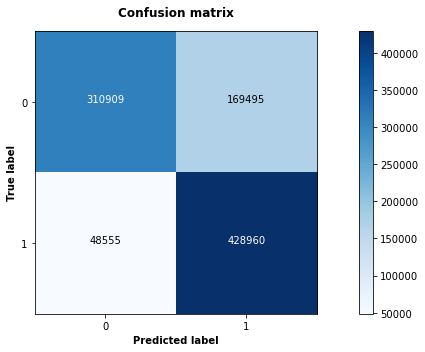

In [11]:
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, np.round(y_pred_meta_rf.ravel()) , labels=[0, 1])  # (957919,)，Series & array


plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

print((cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(cnf_matrix).sum())


0.7727498509248139


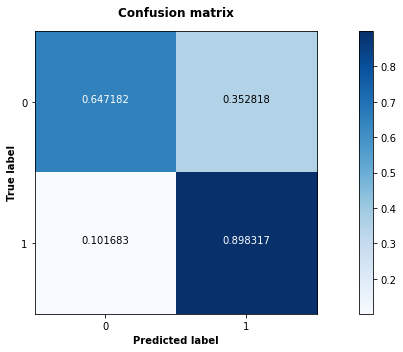

In [12]:
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, np.round(y_pred_meta_rf.ravel()) , labels=[0, 1])  # (957919,)，Series & array
cnf_matrix = cnf_matrix/cnf_matrix.sum(axis=1)[:,np.newaxis]                              # 轉百分比

plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

print((cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(cnf_matrix).sum())


**KDE plot**

<AxesSubplot:ylabel='Density'>

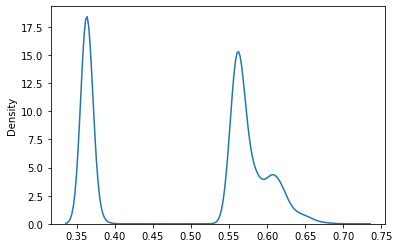

In [13]:
sns.kdeplot( max_depth_5.ravel() )

In [14]:
# max_depth = 60


Xtrain = Xtrain.fillna(0)                         # 補 0
Xtest = Xtest.fillna(0)                           # RFs 不能有 NaN，
                                                  # python 裡 sklearn 不能，pycaret 能，原理上隨機森林是支持有缺失值的
##### Set your configuration(配置) here!!

FOLD = 5                                          # 切 5 分
SEEDS = [24, 42]                                  # 要做幾次 K-fold ,這裡做 2 次

fet_imp = 0                                       # feature importance (not necessary)  # 看特徵重要性
counter = 0                                       # 整個迴圈的個數
oof_score = 0                                     # oof_score /= float(counter)，整個 kfold 的平均分數，roc_auc_score                         

##### here I use XGBoost to implement KFold, you may choose your model by your self
y_pred_final_rf = np.zeros((Xtest.shape[0], 1))   # 建 2維 0 陣列
y_pred_meta_rf = np.zeros((Xtrain.shape[0], 1))  

##### your chosen seeds
for sidx, seed in tqdm(enumerate(SEEDS)):         # enumerate(枚舉) : 看list物件，(0,24) 第一次 & (1,42) 第二次
    seed_score = 0                                # 累積每次 kfold 完分數，後面拿去算每次的平均分數

    ##### start KFold

    kfold = KFold(n_splits=FOLD, shuffle=True, random_state=seed)   # shuffle : 打亂，第 n 次的 random_state 
  # kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed) 

    for flod_idx, (train_idx, val_idx) in enumerate(kfold.split(Xtrain.values, Ytrain.values)): 
                                  # ('f1:f118' & 'claim') 分別對 data 跟 label 切出訓練 & 驗證集，後面 fit 用
                                  # kfold.split : 生成 index 以將數據拆分為訓練集和測試集 
                                  # KFold()方法中的 split()：split(a,b)：方法會根據折數對 a 和 b 進行劃分，返回相應數據的下標
                                  # DF --> array , Xtrain.values (957919, 118)    
        counter += 1              # 整個做到第 (kfold 裡切幾次*做幾次 kflod) 次 

        ##### setting sub training data and validation data
        train_x, train_y = Xtrain.iloc[train_idx], Ytrain.iloc[train_idx]     # 拿出切好的訓練 & 驗證集 (train, val)
        val_x, val_y = Xtrain.iloc[val_idx], Ytrain.iloc[val_idx]             # K-Flod 做完

############################################################################  # 以下以 Random forest 為例  ###############
        ##### This is nothing to do with KFold (建)

        rf_model = RandomForestClassifier(max_depth=60, max_features= 'sqrt',
                                          max_samples=None, criterion= 'gini',
                                          oob_score=True, bootstrap=True)
        rf_model.fit(train_x, train_y)
        # y_new = rf_model.predict(Xtrain)      

        ##### predict validation set and testing set       # 預測 驗證集 & 測試集
        
        y_pred = rf_model.predict_proba(val_x)[:,-1]            
        y_pred_meta_rf[val_idx] += np.array([y_pred]).T    # 第 1/5 份驗證集的預測，5次才會滿

        y_pred_final_rf += np.array(rf_model.predict_proba(Xtest)[:,-1]).T.reshape((Xtest.shape[0], 1))  
                                                           # 整個測試集的預測，一次就滿了，要弄回 2維 (493474, 1)
            
#########################################################################################################################            

        ##### calculate your metrics here
        fet_imp += rf_model.feature_importances_          # 樹模型特有，特徵用越多次越重要
                                                          # model.feature_importances_ : 每次特徵的重要性(比例)，總和約為 1
        score = roc_auc_score(val_y, y_pred)              # 算 roc_auc 分數
        oof_score += score                                # 把整個分數加到底
        seed_score += score                               # 累積每次 kfold 完的分數

        ##### metric logger (指標記錄器)
        print("\n Seed-{} | Fold-{} | OOF Score: {} \n".format(seed, flod_idx, score))    
                                                          # 此次(24 & 42)，第 (flod_idx + 1) 個 kfold.split，評分

    print("\n Seed: {} | Aggregate OOF Score: {} \n\n".format(seed, (seed_score / FOLD)))   
                                                          # 此次 random_state，的平均指標分數


fet_imp = fet_imp / float(counter)                        # 整個 Kfold 中的特徵重要性(比例)，總和約為 1
y_pred_meta_rf = y_pred_meta_rf / float(len(SEEDS))       # 驗證集的預測 / 做幾次 kfold                      (平均一次驗證集)
y_pred_final_rf = y_pred_final_rf / float(counter)        # 整個測試集的預測 / (kfold 裡切幾次*做幾次 kflod)  (平均一次測試集)
oof_score /= float(counter)                               # (整個分數加到底 / 整個次數)，整個 kfold 的平均分數，roc_auc_score 

print("Aggregate OOF Score: {}".format(oof_score))


0it [00:00, ?it/s]


 Seed-24 | Fold-0 | OOF Score: 0.7997383688581529 


 Seed-24 | Fold-1 | OOF Score: 0.7990669149145542 


 Seed-24 | Fold-2 | OOF Score: 0.79962551916103 


 Seed-24 | Fold-3 | OOF Score: 0.8001769892452939 



1it [5:02:08, 18128.15s/it]


 Seed-24 | Fold-4 | OOF Score: 0.7993683059321588 


 Seed: 24 | Aggregate OOF Score: 0.799595219622238 



 Seed-42 | Fold-0 | OOF Score: 0.7986236765874141 


 Seed-42 | Fold-1 | OOF Score: 0.8006792334909092 


 Seed-42 | Fold-2 | OOF Score: 0.7982417104993047 


 Seed-42 | Fold-3 | OOF Score: 0.7999114689226849 



2it [9:13:28, 16604.47s/it]


 Seed-42 | Fold-4 | OOF Score: 0.8003058428876731 


 Seed: 42 | Aggregate OOF Score: 0.7995523864775972 


Aggregate OOF Score: 0.7995738030499175


In [15]:
max_depth_60 = y_pred_final_rf   # 測試集
max_depth_60

array([[0.65],
       [0.11],
       [0.62],
       ...,
       [0.77],
       [0.2 ],
       [0.69]])

**confusion_matrix**

0.7723680185902984


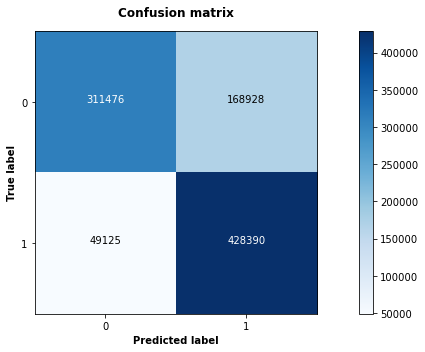

In [16]:
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, np.round(y_pred_meta_rf.ravel()) , labels=[0, 1])  # (957919,)，Series & array


plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

print((cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(cnf_matrix).sum())


0.772743139343641


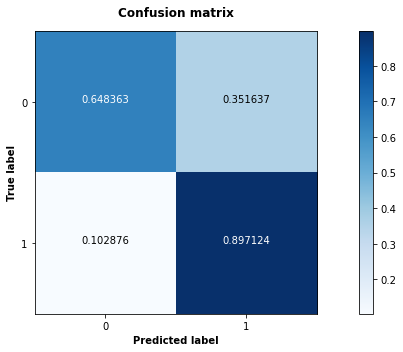

In [17]:
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, np.round(y_pred_meta_rf.ravel()) , labels=[0, 1])  # (957919,)，Series & array
cnf_matrix = cnf_matrix/cnf_matrix.sum(axis=1)[:,np.newaxis]                              # 轉百分比

plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

print((cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(cnf_matrix).sum())


**KDE plot**

<AxesSubplot:ylabel='Density'>

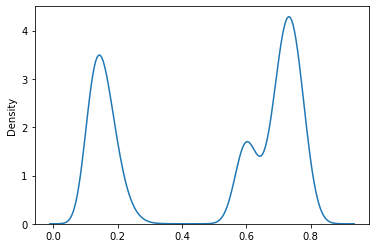

In [18]:
sns.kdeplot( max_depth_60.ravel() )

In [21]:
depth_51 = pd.DataFrame(max_depth_5)
depth_601 = pd.DataFrame(max_depth_60)

In [23]:
random_forest = pd.concat((Xtest.reset_index().iloc[:,0], depth_51, depth_601), axis = 'columns')  # 需要轉 dataframe
random_forest.columns = ['id', 'max_depth_5', 'max_depth_60']
random_forest

,id,max_depth_5,max_depth_60
0,957919,0.553914,0.653503
1,957920,0.362454,0.107132
2,957921,0.554928,0.621970
3,957922,0.362015,0.129830
4,957923,0.362685,0.170366
...,...,...,...
493469,1451388,0.561253,0.742159
493470,1451389,0.361851,0.151462
493471,1451390,0.619570,0.766042
493472,1451391,0.361571,0.204669


In [24]:
# random_forest.to_csv("C:/Users/user/Desktop/random_forest_hat.csv") 

# CatBoost

CatBoost : https://ithelp.ithome.com.tw/articles/10275263

CatBoostClassifier : https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier